# Slenderness $l/d$ vs $\rho$ curves for limiting deflections
This notebook presents slenderness $l/d$ vs $\rho$ curves that are used for limiting deflections according to EC2. Steel curves are reproduced and carbon curves are investigated.

## Background

Based on section 7.4.2 of the EC2 (Nachweis der Begrenzung der Verformungen ohne direkte Berechnung; Cases where calculations may be omitted)

##### eq (7.16.a): 

$$\dfrac{l}{d} = K.\left[11+1.5\sqrt{f_{ck}}\dfrac{\rho_0}{\rho} + 3.2\sqrt{f_{ck}}.\sqrt{\left(\dfrac{\rho_0}{\rho} - 1\right)^3}\right] \mathrm{if} \rho \leq \rho_0$$

$$ \dfrac{l}{d} = K.\left[11+1.5\sqrt{f_{ck}}\dfrac{\rho_0}{\rho- \rho^\prime} + \dfrac{1}{12}\sqrt[2]{f_{ck}}.\sqrt{(\dfrac{\rho^\prime}{\rho_0})}\right] \mathrm{if} \rho > \rho_0 $$

| Symbol | Unit | Description
| :-: | :-: | :- |
| $\dfrac{l}{d}$ | - | the limit value of the bending slenderness (ratio of span to effective height) |
| K | - | the coefficient for consideration of the different static systems according to Table 7.4N |
| $\rho_0$ | - | the reference reinforcement ratio, $\rho_0 = 10^{-3}.\sqrt{f_{ck}}$ |
| $\rho$ | - | the required ratio of tensile reinforcement in the center of the span to resist the design moment (at the restraint section for cantilever beams) |
| $\rho^\prime$ | - | the required ratio of compression reinforcement in the center of the span to resist the design moment (at the restraint section for cantilever beams) |
| $f_{ck}$ | Mpa | the Characteristic cylinder compressive strength of the concrete after 28 days |

In [ ]:
%matplotlib widget
# %matplotlib qt
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import sympy as sp
from sympy import symbols
import bmcs_utils.api as bu
from bmcs_cross_section.api import MKappa, TShape, EC2, BarLayer, ReinfLayer
from bmcs_beam.api import BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, BeamSLSCurve
from os.path import join
from mpl_toolkits import mplot3d
sp.init_printing()

In [ ]:
# Concrete C30/37

f_ck = 70

b = 1000
h = 300
d = 0.9 * h

E = EC2.get_E_cm(f_ck)

fctk_0_05 = EC2.get_f_ctk_0_05(f_ck)
f_ctd = fctk_0_05
# f_ctd = 0.85 * fctk_0_05 / 1.5
f_ctd_fl = max((1.6 - h /1000) * f_ctd, f_ctd)

f_ctm = EC2.get_f_ctm(f_ck)
print(f_ctm)
# Info: eps_cr =  0.000170 with default concrete law gives good slenderness curve

mc = MKappa(low_kappa = 0, high_kappa = 0.00003)

# mc.cs_design.matrix='EC2 with plateau'
mc.cs_design.matrix_.trait_set(
        E_cc=E,
        E_ct=E,
        eps_cr=2.5* f_ctd_fl /E, #0.000125 * f_ck/30, # f_ctm /E,
        eps_cy=EC2.get_eps_c2(f_ck),
        eps_cu=EC2.get_eps_cu2(f_ck),
        eps_tu=0.002,
        mu=0.0,
    f_cd = f_ck, # f_ck * 0.85/1.5,
    factor = 0.85/1.5
    )

mc.cross_section_shape_.B = b
mc.cross_section_shape_.H = h

rho = 0.01
A_s= rho * b * d

bl1 = ReinfLayer(name='layer1', z=h-d, A=A_s, matmod='steel')
bl1.matmod_.trait_set(E_s=200000, f_sy=500, factor = 1./1.15)
mc.cross_section_layout.add_layer(bl1)

dp = DeflectionProfile(mc=mc)
dp.beam_design.beam_conf_name = BoundaryConfig.SIMPLE_BEAM_DIST_LOAD
# dp.beam_design.beam_conf_name = BoundaryConfig.FIXED_AND_ROLLER_SUPPORT_DIST_LOAD
# dp.beam_design.beam_conf_name = BoundaryConfig.FIXED_SUPPORT_DIST_LOAD
# dp.beam_design.beam_conf_name = BoundaryConfig.CANTILEVER_DIST_LOAD

dp.F_scale = 1
dp.beam_design.L = 10 * d # l/d = 10

In [ ]:
# beam_sls = BeamSLSCurve(dp = dp)
# beam_sls.interact()

### Load-Deflection profile analysis

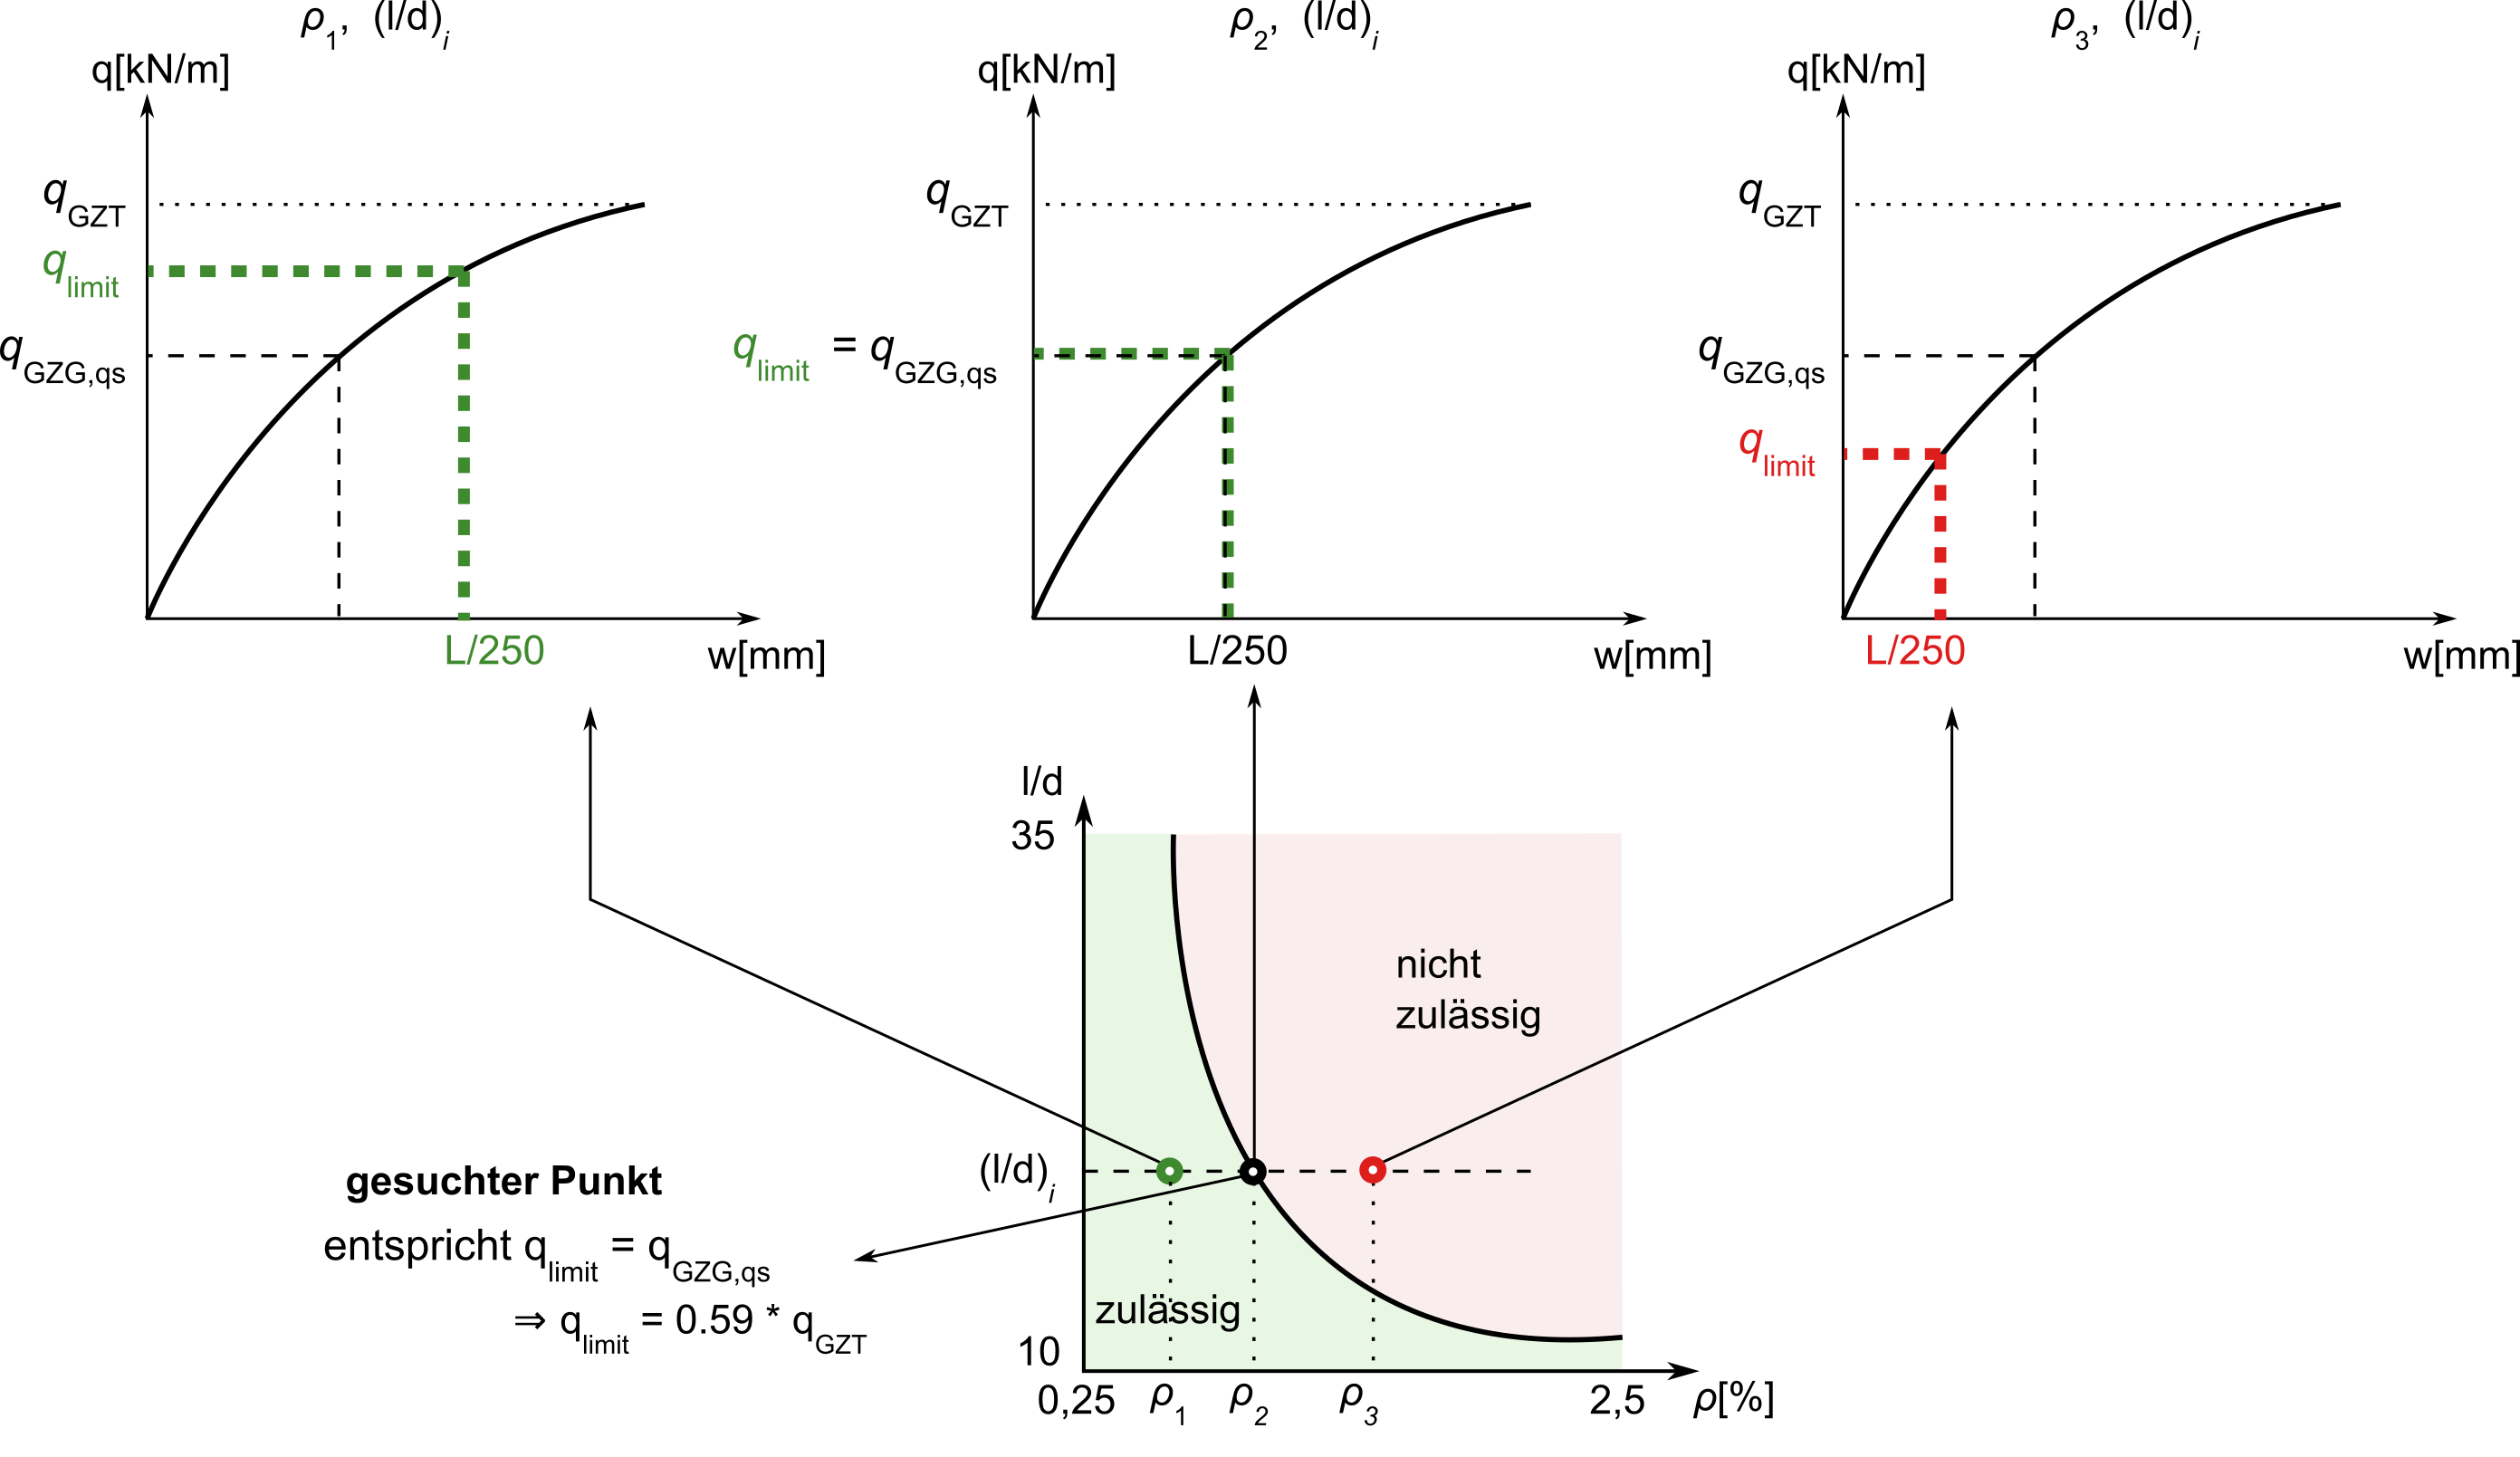

![generating_slenderness_curves.png](attachment:generating_slenderness_curves.png)

| Symbol | Unit | Description
| :-: | :-: | :- |
| $F_{s}$ | - | the load corresponds to L/250 |
| $F_{u}$ | - | the ultimate load |
| $w_{s}$ | - | the deflection L/250 |
| $w_{u}$ | - | the ultimate deflection |  

In [ ]:
# def get_Fu_and_Fs(dp, n_i, rho_range=(0.0025, 0.025), slenderness_range=(10, 35), upper_reinforcement = False):
#     rho_range = np.linspace(*rho_range, n_i)
#     slenderness_range = np.linspace(*slenderness_range, n_i)

def get_Fu_and_Fs(dp, rho_range=np.linspace(0.0025, 0.025), slenderness_range=np.linspace(10, 35), upper_reinforcement = False):
    if upper_reinforcement:
        d = mc.cross_section_layout.items[0].z
    else:
        d = dp.mc.cross_section_shape_.H -  mc.cross_section_layout.items[0].z
    b = dp.mc.cross_section_shape_.B
    area_g = b * d

    rho_grid, sl_grid = np.meshgrid(rho_range, slenderness_range) 
    F_u_grid = np.zeros_like(rho_grid)
    F_s_grid = np.zeros_like(rho_grid)

    _ , ax = plt.subplots()
    ax.set_xlabel(r'$w$ [mm]')
    ax.set_ylabel(r'$F$ [KN]')

    for sl_idx in range(0,len(slenderness_range)):
        for rho_idx in range(0,len(rho_range)):      
            rho = rho_grid[rho_idx, sl_idx]
            sl = sl_grid[rho_idx, sl_idx]

            print('parameter combination', rho, sl)

            # assigning the grid area (area_g) to the reinforcement area variable
            A_j_g = rho * area_g
            dp.mc.cross_section_layout.items[0].A = A_j_g

            # assigning the grid length (L_g) to the beam length variable
            L_g = sl * d
            dp.beam_design.L = L_g
            
            dp.mc.state_changed = True

            # running the deflection analysis 
            F_data, w_data = dp.get_Fw()

            # plotting, post-processing & saving the data
            ax.plot(w_data, F_data/1000, label = "rho={}%-sl={} ".format(rho * 100, sl))

            w_s = dp.beam_design.L / 250
            F_u = max(F_data)
            F_s = np.interp(w_s, w_data, F_data, right=F_u*2)

            F_u_grid[rho_idx,sl_idx] = F_u
            F_s_grid[rho_idx,sl_idx] = F_s
            
    return F_u_grid, F_s_grid, rho_grid, sl_grid

In [ ]:
def save_data_vars_in_json(f_ck, mc, dp, path):
    rein = mc.cross_section_layout.items
    output_data = {'mc.n_m': mc.n_m,
                  'mc.n_kappa': mc.n_kappa,
                'mc.low_kappa': mc.low_kappa,
                  'mc.high_kappa': mc.high_kappa,
                  'mc.E_cc': mc.cs_design.matrix_.E_cc,
                  'mc.E_ct': mc.cs_design.matrix_.E_ct,
                  'mc.eps_tu': mc.cs_design.matrix_.eps_tu,
                  'mc.eps_cr': mc.cs_design.matrix_.eps_cr,
                  'mc.eps_cy': mc.cs_design.matrix_.eps_cy,
                  'mc.eps_cu': mc.cs_design.matrix_.eps_cu,
                  'mc.mu': mc.cs_design.matrix_.mu,
                  'f_ck': f_ck,
                  'rein[0].E':rein[0].matmod_.E,
                  'rein[0].z': rein[0].z,
                  'rein[0].A': rein[0].A,
                  'dp.beam_design.L': dp.beam_design.L,}
    with open(path, 'w') as outfile:
        json.dump(output_data, outfile, sort_keys=True, indent=4)

## Verification with EC2 assumptions

### 1. EC2 - Steel

In [ ]:
# Concrete C30/37

f_ck = 70

b = 1000
h = 300
d = 0.9 * h

E = EC2.get_E_cm(f_ck)

fctk_0_05 = EC2.get_f_ctk_0_05(f_ck)
f_ctd = fctk_0_05
# f_ctd = 0.85 * fctk_0_05 / 1.5
f_ctd_fl = max((1.6 - h /1000) * f_ctd, f_ctd)

f_ctm = EC2.get_f_ctm(f_ck)
print(f_ctm)
# Info: eps_cr =  0.000170 with default concrete law gives good slenderness curve

mc = MKappa(low_kappa = 0, high_kappa = 0.00003)

# mc.cs_design.matrix='EC2 with plateau'
mc.cs_design.matrix_.trait_set(
        E_cc=E,
        E_ct=E,
        eps_cr=2.5* f_ctd_fl /E, #0.000125 * f_ck/30, # f_ctm /E,
        eps_cy=EC2.get_eps_c2(f_ck),
        eps_cu=EC2.get_eps_cu2(f_ck),
        eps_tu=0.002,
        mu=0.0,
    f_cd = f_ck, # f_ck * 0.85/1.5,
    factor = 0.85/1.5
    )

mc.cross_section_shape_.B = b
mc.cross_section_shape_.H = h

rho = 0.01
A_s= rho * b * d

bl1 = ReinfLayer(name='layer1', z=h-d, A=A_s, matmod='steel')
bl1.matmod_.trait_set(E_s=200000, f_sy=500, factor = 1./1.15)
mc.cross_section_layout.add_layer(bl1)

dp = DeflectionProfile(mc=mc)
dp.beam_design.beam_conf_name = BoundaryConfig.SIMPLE_BEAM_DIST_LOAD
# dp.beam_design.beam_conf_name = BoundaryConfig.FIXED_AND_ROLLER_SUPPORT_DIST_LOAD
# dp.beam_design.beam_conf_name = BoundaryConfig.FIXED_SUPPORT_DIST_LOAD
# dp.beam_design.beam_conf_name = BoundaryConfig.CANTILEVER_DIST_LOAD

dp.F_scale = 1
dp.beam_design.L = 10 * d # l/d = 10

In [ ]:
dp.interact()

In [ ]:
F_u_grid, F_s_grid, rho_grid, sl_grid = get_Fu_and_Fs(dp, 6)
# F_u_grid, F_s_grid, rho_grid, sl_grid = get_Fu_and_Fs(dp, 7, upper_reinforcement = True, rho_range=(0.001, 0.025), slenderness_range=(3, 50))

In [ ]:
np.save('F_u_grid_steel_EC2_eq2_tension_c' + str(f_ck) + '.npy', F_u_grid)
np.save('F_s_grid_steel_EC2_eq2_tension_c' + str(f_ck) + '.npy', F_s_grid)
np.save('rho_grid_steel_EC2_eq2_tension_c' + str(f_ck) + '.npy', rho_grid)
np.save('sl_grid_steel_EC2_eq2_tension_c' + str(f_ck) + '.npy', sl_grid)
save_data_vars_in_json(f_ck, mc, dp, 'data_steel_EC2_eq2_tension_c' + str(f_ck) + '.json')

In [ ]:
fig, ax = plt.subplots()

z = F_u_grid / F_s_grid - 1./0.59
CS = ax.contour(rho_grid, sl_grid, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_ylabel('L/d')
ax.set_xlabel(r'$\rho$ %')
ax.set_ylim(0, 35)
ax.set_xlim(0.0, 0.025)

# Draw EC2 curve
slenderness = BeamSLSCurve().plot_steel_sls_curves(ax=ax, f_cks=[70])

### Plotting all curves

In [ ]:
f_cks = [30, 50, 70]
F_u_grids = []
F_s_grids = []
rho_grids = []
sl_grids = []
reinforcement = 'steel'
for f_ck in f_cks:
    f_ck = str(f_ck)
    
    F_u_grid = np.load('F_u_grid_' + reinforcement + '_EC2_eq2_tension_c' + f_ck + '.npy')
    F_s_grid = np.load('F_s_grid_' + reinforcement + '_EC2_eq2_tension_c' + f_ck + '.npy')
    rho_grid = np.load('rho_grid_' + reinforcement + '_EC2_eq2_tension_c' + f_ck + '.npy')
    sl_grid = np.load('sl_grid_' + reinforcement + '_EC2_eq2_tension_c' + f_ck + '.npy')
    
#     F_u_grid = np.load('F_u_grid_' + reinforcement + '_c' + f_ck + '.npy')
#     F_s_grid = np.load('F_s_grid_' + reinforcement + '_c' + f_ck + '.npy')
#     rho_grid = np.load('rho_grid_' + reinforcement + '_c' + f_ck + '.npy')
#     sl_grid = np.load('sl_grid_' + reinforcement + '_c' + f_ck + '.npy')
    
    F_u_grids.append(F_u_grid)
    F_s_grids.append(F_s_grid)
    rho_grids.append(rho_grid)
    sl_grids.append(sl_grid)


In [ ]:
fig, ax = plt.subplots(1,1)

ax.set_ylabel('L/d')
ax.set_xlabel(r'$\rho$ %')
ax.set_ylim(0, 35)
ax.set_xlim(0.0, 0.025)

for f_ck, F_u_grid, F_s_grid, rho_grid, sl_grid in zip(f_cks, F_u_grids, F_s_grids, rho_grids, sl_grids):
    color = np.random.rand(3,)
    z = F_u_grid / F_s_grid - 1./0.59
    CS = ax.contour(rho_grid, sl_grid, z, levels=[0], colors=[color])
    CS.collections[0].set_label('C' + str(f_ck))
#     ax.clabel(CS, inline=1, fontsize=10)

    # Draw EC2 curve
    rho_range = np.arange(0.0025, 0.025, 0.0001)
    slenderness = get_slenderness(rho_range, 0,  1, f_ck)
    ax.plot(rho_range, slenderness, label='C' + str(f_ck) + '_EC2', ls='--', c = color)
        
ax.legend()
# fig.savefig('test.pdf')

### 2. EC2 - Carbon

In [ ]:
for E_t in [230]:
    f_ck = 30
    b = 1000
    h = 300
    d = 0.9 * h

    E = EC2.get_E_cm(f_ck)
    
    fctk_0_05 = EC2.get_f_ctk_0_05(f_ck)
    f_ctd = fctk_0_05
    # f_ctd = 0.85 * fctk_0_05 / 1.5
    f_ctd_fl = max((1.6 - h /1000) * f_ctd, f_ctd)

    eps_cr = f_ctd_fl/E
    print(eps_cr)

    mc = MKappa(low_kappa = 0, 
                high_kappa = 0.00004, # high_kappa = 0.00009

                # Cantilever
    #             low_kappa = -0.00005,
    #             high_kappa =  0,
               ) 
    mc.cs_design.matrix='EC2 with plateau'
    mc.cs_design.matrix_.trait_set(
            E_cc=E,
            E_ct=E,
            eps_cr=eps_cr, #0.000132 * f_ck/30,
            eps_cy=EC2.get_eps_c2(f_ck),
            eps_cu=EC2.get_eps_cu2(f_ck),
            eps_tu=0.002,
            mu=0.0,
        f_cd = f_ck*0.85/1.5,
    #     factor = 0.85/1.5
        )  

    mc.cross_section_shape_.B = b
    mc.cross_section_shape_.H = h

    rho = 0.01
    # A_s=6 * np.pi * (32/2)**2
    A_s= 0.5 * rho * b * d

    bl1 = ReinfLayer(name='layer1', z=h-d, A=A_s, matmod='carbon')
    bl1.matmod_.trait_set(E=E_t*1000, f_t=3000, factor = 1./1.5)
    mc.cross_section_layout.add_layer(bl1)

    dp = DeflectionProfile(mc=mc)
    dp.beam_design.beam_conf_name = BoundaryConfig.SIMPLE_BEAM_DIST_LOAD
    # dp.beam_design.beam_conf_name = BoundaryConfig.FIXED_AND_ROLLER_SUPPORT_DIST_LOAD
    # dp.beam_design.beam_conf_name = BoundaryConfig.FIXED_SUPPORT_DIST_LOAD
    # dp.beam_design.beam_conf_name = BoundaryConfig.CANTILEVER_DIST_LOAD

    dp.F_scale = 1
    dp.beam_design.L = 10 * d
    
#     dp.interact()

    rho1 = np.linspace(0.0005, 0.007, 7)
    rho2 = np.linspace(0.0075, 0.025, 5)
    rho_range=np.concatenate((rho1, rho2))

    sl1 = np.linspace(3, 10, 7)
    sl2 = np.linspace(11, 50, 5)
    slenderness_range=np.concatenate((sl1, sl2))
   

    F_u_grid, F_s_grid, rho_grid, sl_grid = get_Fu_and_Fs(dp, rho_range=rho_range, slenderness_range=slenderness_range)
    
    np.save('F_u_grid_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.npy', F_u_grid)
    np.save('F_s_grid_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.npy', F_s_grid)
    np.save('rho_grid_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.npy', rho_grid)
    np.save('sl_grid_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.npy', sl_grid)
    save_data_vars_in_json(f_ck, mc, dp, 'data_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.json')

#F_u_grid, F_s_grid, rho_grid, sl_grid = get_Fu_and_Fs(dp, 12, rho_range=(0.0005, 0.025), slenderness_range=(3, 50))

In [ ]:
np.save('F_u_grid_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.npy', F_u_grid)
np.save('F_s_grid_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.npy', F_s_grid)
np.save('rho_grid_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.npy', rho_grid)
np.save('sl_grid_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.npy', sl_grid)
save_data_vars_in_json(f_ck, mc, dp, 'data_carbon_EC2_eq2_tension_E' + str(E_t) + '_ft_1500_c' + str(f_ck) + '.json')

In [ ]:
# Concrete C30/37

f_ck = 30

b = 1000
h = 300
d = 0.9 * h

E = EC2.get_E_cm(f_ck)

mc = MKappa(low_kappa = 0, 
            high_kappa = 0.00004, # high_kappa = 0.00009
           
            # Cantilever
#             low_kappa = -0.00005,
#             high_kappa =  0,
           ) 
mc.cs_design.matrix='EC2 with plateau'
mc.cs_design.matrix_.trait_set(
        E_cc=E,
        E_ct=E,
        eps_cr=0.000132 * f_ck/30,
        eps_cy=EC2.get_eps_c2(f_ck),
        eps_cu=EC2.get_eps_cu2(f_ck),
        eps_tu=0.002,
        mu=0.0,
    f_cd = f_ck*0.85/1.5,
#     factor = 0.85/1.5
    )  

mc.cross_section_shape_.B = b
mc.cross_section_shape_.H = h

rho = 0.01
# A_s=6 * np.pi * (32/2)**2
A_s= 0.5 * rho * b * d

bl1 = ReinfLayer(name='layer1', z=h-d, A=A_s, matmod='carbon')
bl1.matmod_.trait_set(E=100000, f_t=1000, factor = 1./1.5)
mc.cross_section_layout.add_layer(bl1)

dp = DeflectionProfile(mc=mc)
dp.beam_design.beam_conf_name = BoundaryConfig.SIMPLE_BEAM_DIST_LOAD
# dp.beam_design.beam_conf_name = BoundaryConfig.FIXED_AND_ROLLER_SUPPORT_DIST_LOAD
# dp.beam_design.beam_conf_name = BoundaryConfig.FIXED_SUPPORT_DIST_LOAD
# dp.beam_design.beam_conf_name = BoundaryConfig.CANTILEVER_DIST_LOAD

dp.F_scale = 1
dp.beam_design.L = 1000
# dp.beam_design.L = 10 * d # l/d = 10
# dp.interact()

In [ ]:
F_u_grid, F_s_grid, rho_grid, sl_grid = get_Fu_and_Fs(dp, 4, rho_range=(0.0005, 0.025), slenderness_range=(3, 50))
# F_u_grid, F_s_grid, rho_grid, sl_grid = get_Fu_and_Fs(dp, 7, rho_range=(0.001, 0.025), slenderness_range=(3, 50), 
#                                                       upper_reinforcement = True)

In [ ]:
_, ax = plt.subplots(1,1)

z = F_u_grid / F_s_grid - 1./0.59

CS = ax.contour(rho_grid, sl_grid, z, levels=[0])
ax.clabel(CS, inline=1, fontsize=10)
ax.set_ylabel('L/d')
ax.set_xlabel(r'$\rho$ %')
ax.set_ylim(0, 35)
ax.set_xlim(0.0, 0.025)

# Draw C30 curve
rho_range = np.arange(0.0025, 0.025, 0.0001)
f_ck = 30
slenderness = get_slenderness(rho_range, 0,  1, f_ck)
ax.plot(rho_range, slenderness, c=np.random.rand(3,))

In [ ]:
# Checking stress status for different rho, sl

# Initializing dp
# ---------------------------------------------------------------
# Concrete C30/37

f_ck = 30

b = 1000
h = 300
d = 0.9 * h

E = EC2.get_E_cm(f_ck)

mc = MKappa(low_kappa = 0, high_kappa = 0.00007) # high_kappa = 0.00009
mc.cs_design.matrix='EC2 with plateau'
mc.cs_design.matrix_.trait_set(
        E_cc=E,
        E_ct=E,
        eps_cr=0.000132 * f_ck/30,
        eps_cy=EC2.get_eps_c2(f_ck),
        eps_cu=EC2.get_eps_cu2(f_ck),
        eps_tu=0.002,
        mu=0.0,
    f_cd = f_ck*0.85/1.5,
#     factor = 0.85/1.5
    )  

mc.cross_section_shape_.B = b
mc.cross_section_shape_.H = h

# Steel
# bl1 = ReinfLayer(name='layer1', z=h-d, matmod='steel')
# bl1.matmod_.trait_set(E_s=200000, f_sy=500, factor = 1./1.15)

# Carbon
bl1 = ReinfLayer(name='layer1', z=h-d, matmod='carbon')
bl1.matmod_.trait_set(E=100000, f_t=1500, factor = 1./1.5)

mc.cross_section_layout.add_layer(bl1)

dp = DeflectionProfile(mc=mc)
dp.beam_design.beam_conf_name = BoundaryConfig.SIMPLE_BEAM_DIST_LOAD
# ---------------------------------------------------------------
# Setting rho and sl:

rho = 0.0013
sl = 10

dp.mc.cross_section_layout.items[0].A = rho * b * d
dp.beam_design.L = sl * d

dp.mc.state_changed = True

F_data, w_data = dp.get_Fw()
w_s = dp.beam_design.L / 250
F_u = max(F_data)
F_s = np.interp(w_s, w_data, F_data, right=F_u*2)

print('w_limit = ',w_s)
print('q_ULT = ', F_u)
print('q_SLS = ', 0.59 * F_u)
print('q_limit = ',F_s)

dp.interact()

In [ ]:
f_ck = 200
np.save('F_u_grid_carbon_EC2_eq2_tension_c' + str(f_ck) + '.npy', F_u_grid)
np.save('F_s_grid_carbon_EC2_eq2_tension_c' + str(f_ck) + '.npy', F_s_grid)
np.save('rho_grid_carbon_EC2_eq2_tension_c' + str(f_ck) + '.npy', rho_grid)
np.save('sl_grid_carbon_EC2_eq2_tension_c' + str(f_ck) + '.npy', sl_grid)
save_data_vars_in_json(f_ck, mc, dp, 'data_carbon_EC2_eq2_tension_c' + str(f_ck) + '.json')

### Plotting all curves

In [ ]:
f_cks = [30]
F_u_grids = []
F_s_grids = []
rho_grids = []
sl_grids = []
reinforcement = 'carbon'
for f_ck in f_cks:
    f_ck = str(f_ck)
#     F_u_grids.append(np.load('F_u_grid_' + reinforcement + '_EC2_eq2_tension_c' + f_ck + '.npy'))
#     F_s_grids.append(np.load('F_s_grid_' + reinforcement + '_EC2_eq2_tension_c' + f_ck + '.npy'))
#     rho_grids.append(np.load('rho_grid_' + reinforcement + '_EC2_eq2_tension_c' + f_ck + '.npy'))
#     sl_grids.append(np.load('sl_grid_' + reinforcement + '_EC2_eq2_tension_c' + f_ck + '.npy'))
    
    F_u_grids.append(np.load('F_u_grid_' + reinforcement + '_EC2_eq2_tension_E230_ft_1500_c' + f_ck + '.npy'))
    F_s_grids.append(np.load('F_s_grid_' + reinforcement + '_EC2_eq2_tension_E230_ft_1500_c' + f_ck + '.npy'))
    rho_grids.append(np.load('rho_grid_' + reinforcement + '_EC2_eq2_tension_E230_ft_1500_c' + f_ck + '.npy'))
    sl_grids.append(np.load('sl_grid_' + reinforcement + '_EC2_eq2_tension_E230_ft_1500_c' + f_ck + '.npy'))

In [ ]:
_, ax = plt.subplots(1,1)

ax.set_ylabel('L/d')
ax.set_xlabel(r'$\rho$ %')
ax.set_ylim(0, 35)
ax.set_xlim(0.0, 0.025)

for f_ck, F_u_grid, F_s_grid, rho_grid, sl_grid in zip(f_cks, F_u_grids, F_s_grids, rho_grids, sl_grids):
    z = F_u_grid / F_s_grid - 1./0.59
    CS = ax.contour(rho_grid, sl_grid, z, levels=[0], colors=[np.random.rand(3,)])
    CS.collections[0].set_label('C' + str(f_ck))
#     ax.clabel(CS, inline=1, fontsize=10)
    
    BeamSLSCurve().plot_steel_sls_curves(ax=ax, f_cks=[30], axes_start_from_zero=True)

ax.legend()


## Testing for Steel
#### 1. Verification with Gribniak et al. (2012), https://doi.org/10.1016/j.engstruct.2012.04.032, Steel reinforcement

In [ ]:
mc_params = dict(
            reinforcement_type= ReinforcementType.STEEL,
            apply_material_safety_factors = True,
    
            n_m=100,
            n_kappa = 100,
            kappa_slider = 0.000001,
            low_kappa = 0,
            high_kappa =  0.00002, # 12e-6,
            eps_tu = 0.002508,
            E_cc = 34000,
            E_ct = 34000,
            eps_cr = 0.000132,
            eps_cy = 0.0015312,
            mu = 0.0,            # I changed this to zero
            eps_cu = 0.003498)

mc = MKappa(**mc_params)

# mc.cross_section_shape.B =284
# mc.cross_section_shape.H =298
# mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=560/203000, E=203000, z=26.82, A=231.04536)]

b = 300
h = 300
mc.cross_section_shape.B = b
mc.cross_section_shape.H = h
rho = 0.01

mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=(500/1.15)/203000, E=203000, z=25, A=rho * b * (h - 25))]

dp = DeflectionProfile(mc=mc)
dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.L = 3000
dp.beam_design.beam_conf_name.first_load_distance = dp.beam_design.L/3

bu.InteractiveWindow([dp, 
                      dp.beam_design, 
                      dp.mc, 
                      dp.mc.cs_design.cross_section_shape, 
                      dp.mc.cs_design.cross_section_layout], tight_layout=True).interact()

In [ ]:
F_u_grid, F_s_grid = get_Fu_and_Fs(dp, 4)

In [ ]:
np.save('F_u_grid_steel_with_material_factors_applied_on_material_law.npy', F_u_grid)
np.save('F_s_grid_steel_with_material_factors_applied_on_material_law.npy', F_s_grid)
# np.save('F_u_grid_steel.npy', F_u_grid)
# np.save('F_s_grid_steel.npy', F_s_grid)

In [ ]:
# This cell is for loading results later if needed
rho_range = np.linspace(0.0025, 0.025, 4)
slenderness_range = np.linspace(10, 35, 4)
rho_grid, sl_grid = np.meshgrid(rho_range, slenderness_range) 
F_u_grid = np.load('F_u_grid_steel_with_1_material_param.npy') # ('F_u_grid_steel_with.npy')
F_s_grid = np.load('F_s_grid_steel_with_1_material_param.npy') # ('F_s_grid_steel_with.npy')

In [ ]:
_, ax = plt.subplots(1,1)
# z = F_u_grid - F_s_grid
# z = F_u_grid / F_s_grid - 1.5

# z = 0.51 *  F_u_grid - F_s_grid

z = F_u_grid / F_s_grid - 1./0.51

CS = ax.contour(rho_grid, sl_grid, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_ylabel('L/d')
ax.set_xlabel(r'$\rho$ %')
ax.set_ylim(10, 35)
ax.set_xlim(0.0025, 0.025)

# Draw C50 curve
rho_range = np.arange(0.0025, 0.025, 0.0001)
f_ck = 50
slenderness = []
for rho in rho_range:
    slenderness.append(get_slenderness(rho, 0,  1, f_ck))
ax.plot(rho_range, slenderness)

In [ ]:
# from mpl_toolkits import mplot3d
# # %matplotlib widget
# # import numpy as np
# import matplotlib.pyplot as plt
# # excel_file = join('./verification_data','assessmentruledata.xlsx')
# # df = data = pd.read_excel(excel_file)

# # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8 , 8))

# # X, Y = np.meshgrid(df['sl'], df['rho'])
# # FU, FS = np.meshgrid(df['F_u'], df['F_s'])
# # WU, WS = np.meshgrid(df['w_u'], df['w_s'])

# # Z = np.array(FU / FS)

# # fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(sl_grid, rho_grid, F_u_grid/F_s_grid - 1, 500, cmap='rainbow')
# ax.set_xlabel('L/d')
# ax.set_ylabel(r'$\rho$')
# ax.set_zlabel('Fu/Fs')
# ax.set_title('Deflection Assessment Rule')
# plt.show()

## Testing for Carbon
#### 1. Verification with Heid et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement


In [ ]:
# Testing for Carbon
# HB-SU-0
E = 39500

# from bending test from σ_c,Riss
eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            apply_material_safety_factors = True,
            
            low_kappa = 0,
            high_kappa = 0.0007,
            E_cc = E,
            E_ct = E,
            eps_cr = eps_cr, # 0.000163
            eps_tu = 9.02/E, # beta_tu = 20
            eps_cy = 72/E, # omega = 10.0
            eps_cu = (72/E)*2, # lambda_cu = 20
            mu = 0.0)

mc.cross_section_shape.B = 45
mc.cross_section_shape.H = 30
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=2712/240000, E=240000, z=8, A=3.62),
                                         Reinforcement(eps_sy=2712/240000, E=240000, z=22, A=3.62),]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 320
dp.beam_design.L = 840

In [ ]:
F_u_grid, F_s_grid, rho_grid, sl_grid = get_Fu_and_Fs(dp, 5)

In [ ]:
np.save('F_u_grid_carbon.npy', F_u_grid)
np.save('F_s_grid_carbon.npy', F_s_grid)

In [ ]:
# This cell is for loading results later if needed
rho_range = np.linspace(0.0025, 0.025, 6)
slenderness_range = np.linspace(10, 35, 6)
rho_grid, sl_grid = np.meshgrid(rho_range, slenderness_range) 
F_u_grid = np.load('F_u_grid_carbon.npy')
F_s_grid = np.load('F_s_grid_carbon.npy')

In [ ]:
_, ax = plt.subplots(1,1)
# z = F_u_grid/F_s_grid -1
z = (F_s_grid + F_u_grid) / F_s_grid - 1.35

CS = ax.contour(rho_grid, sl_grid, z )
ax.clabel(CS, inline=1, fontsize=10)
ax.set_ylabel('L/d')
ax.set_xlabel(r'$\rho$ %')
ax.set_ylim(10, 35)
ax.set_xlim(0.0025, 0.025)

# Draw C50 curve
rho_range = np.arange(0, 0.05, 0.0001)
f_ck = 70
slenderness = []
for rho in rho_range:
    slenderness.append(get_slenderness(rho, 0,  1, f_ck))
ax.plot(rho_range, slenderness)

In [ ]:
# from mpl_toolkits import mplot3d
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
excel_file = join('./verification_data','assessmentruledata.xlsx')
df = data = pd.read_excel(excel_file)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8 , 8))

X, Y = np.meshgrid(df['sl'], df['rho'])
FU, FS = np.meshgrid(df['F_u'], df['F_s'])
WU, WS = np.meshgrid(df['w_u'], df['w_s'])

Z = np.array(FU / FS)

# fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 500, cmap='rainbow')
ax.set_xlabel('L/d')
ax.set_ylabel(r'$\rho$')
ax.set_zlabel('Fu/Fs')
ax.set_title('Deflection Assessment Rule')
plt.show()